<p style="align: center;"><img align=center src="https://s8.hostingkartinok.com/uploads/images/2018/08/308b49fcfbc619d629fe4604bceb67ac.jpg"  width=400></p>

<h3 style="text-align: center;"><b>Физтех-Школа Прикладной математики и информатики (ФПМИ) МФТИ</b></h3>

In [1]:
import torch
from torch import nn
import torch.nn.functional as F
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt

Сгенерируем датасет Игрушка Дьявола

In [2]:
# код для генерации взят из Стэнфордсокго курса:
# http://cs231n.github.io/neural-networks-case-study/#linear

N = 100
D = 2
K = 3
X = np.zeros((N * K, D))
y = np.zeros(N * K, dtype='uint8')

for j in range(K):
    ix = range(N * j,N * (j + 1))
    r = np.linspace(0.0, 1, N)
    t = np.linspace(j * 4, (j + 1) * 4,N) + np.random.randn(N) * 0.2 # theta
    X[ix] = np.c_[r * np.sin(t), r * np.cos(t)]
    y[ix] = j

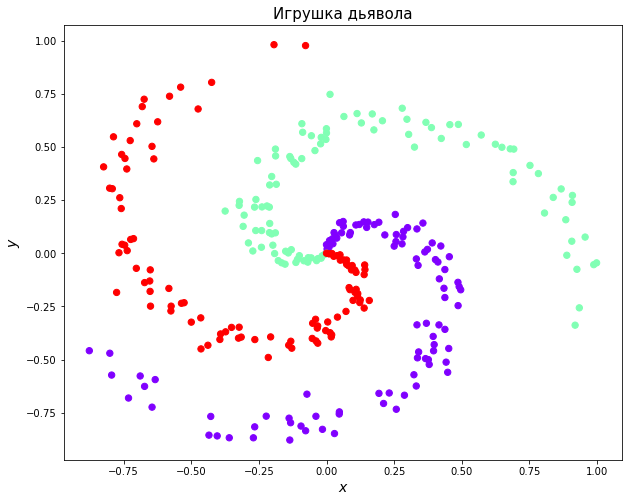

In [3]:
# Отрисовочная магия, снова взято из:
# http://cs231n.github.io/neural-networks-case-study/#linear

plt.figure(figsize=(10, 8))

plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.rainbow)

plt.title('Игрушка дьявола', fontsize=15)
plt.xlabel('$x$', fontsize=14)
plt.ylabel('$y$', fontsize=14)
plt.show();

In [4]:
X = torch.FloatTensor(X)
y = torch.LongTensor(y)

In [5]:
X.shape

torch.Size([300, 2])

Сейчас мы хотим научиться самостоятельно создавать наследников nn.Module. До этого мы делали нейросети с помощью класса nn.Sequential, попробуем построить такую же сеть, как на прошлом семинаре, но самостоятельно.

In [6]:
# СЕТЬ С ПРОШЛОГО СЕМИНАРА

# D_in - размерность входа (количество признаков у объекта);
# H - размерность скрытых слоёв; 
# D_out - размерность выходного слоя (суть - количество классов)
D_in, H, D_out = 2, 100, 3

# Use the nn package to define our model and loss function.
two_layer_net = torch.nn.Sequential(
    torch.nn.Linear(D_in, H),
    torch.nn.ReLU(),
    torch.nn.Linear(H, D_out),
    torch.nn.Softmax()
)

Что такое модуль и как он устроен? Во-первых, модуль это такой строительный блок для нейронок, с помощью модуля можно задать любую дифференциируемую по своему параметру функцию. Применяются модули так же, как и обычные функции с синтаксисом
> module_instance(var1, var2)

При этом внутри вызывается функция forward с теми же аргументами, а ее выход возвращается как результат вызова модуля. Зачем же нужно так странно оборачивать обычные функции в модули? 

* Это позволяет очень удобно следить за параметрами, которые надо изменять. Когда мы хоти получить все параметры можно просто рекурсивно пройтись по всем полям модели, посмотреть, какие из ни параметры сами по себе, а какие являются модулями и содрежат параметры внутри, а потом все это собрать. 

_По этой причине если вы используете внутри своего модуля какие-то еще модули их надо класть просто в поле класса, если это единичный модуль, и в класс **nn.ModuleList** или **nn.ModuleDict**, если у вас список или словарь используемых модулей. Если же в модели у вас есть како-то собственный вес, то недостаточно положить тензор в поле класса, его надо обернуть в **nn.Parameter, nn.ParameterList** или **nn.ParameterDict** в зависимотси от того, что именно у вас._

* Такая организация позволяет достаточно безболезненно расширять PyTorch и писать для него свои функции, которые нельзя выразить композицией уже существующих. Пригождается это редко, поэтому сегодня мы не будем писать свое расширение.

* Код, разделенный на модули, это просто красиво.

In [13]:
# НОВАЯ СЕТЬ

class MyModule(nn.Module):
    def __init__(self):
        super().__init__()
        self.f_lin = nn.Linear(D_in, H)
        self.s_lin = nn.Linear(H, D_out)
        
    def forward(self, X):
        X = F.relu(self.f_lin(X))
        return F.softmax(self.s_lin(X))
    
model = MyModule()
loss_fn = nn.CrossEntropyLoss()
optim = torch.optim.Adam(model.parameters(), 1e-1)

Поговорим немного подробнее о `softmax` и `CrossEntropyLoss`. 

Напоминание: softmax-функция выглядит следующим образом
$$Softmax(x) = \begin{pmatrix} 
\dfrac{e^{x_1}}{\sum\limits_{i=0}^{m} e^{x_i}},\; \dots,\; \dfrac{e^{x_m}}{\sum\limits_{i=0}^{m} e^{x_i}}
\end{pmatrix} $$

Таким образом, после применения softmax-функции мы получили вектор чисел из интервала $(0, 1)$, которые мы будем интерпретировать как вероятности классов.

Аналогично тому, как мы обощили сигмоиду на многоклассовый случай и получили softmax, можно обобщить и функцию потерь, получив _кросс-энтропию_:

$$CrossEntropy(x) = -\sum\limits_{i=0}^m y_i \cdot log(Softmax(x)_i), $$

где $y_i$ – истинная метка класса ($1$ если $x$ принадлежит $i$-ому классу и $0$ иначе)

<ipython-input-7-ecb9deb799b4>:11: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(self.s_lin(X))


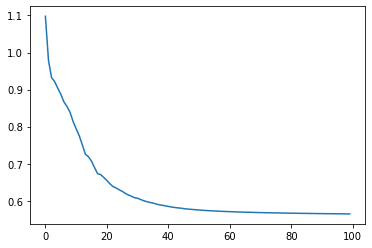

In [8]:
losses = []
for t in range(100):
    # forward
    y_pred = model(X)

    # loss
    loss = loss_fn(y_pred, y)
    losses.append(loss.item())

    optim.zero_grad()
    loss.backward()
    optim.step()
    
plt.plot(losses)

Теперь посмотрим, что будет, если не положить используемые внутри слои в self

In [ ]:
# Сеть без параметров

class MyModule(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear_layers = [nn.Linear(D_in, H), nn.Linear(H, D_out)]
        self.my_useless_bias = torch.ones(1, H, requires_grad=True)
        self.more_of_my_useless_biases = [
            torch.ones(1, H, requires_grad=True),
            torch.ones(1, H, requires_grad=True),
            torch.ones(1, H, requires_grad=True)
        ]
        
    def forward(self, X):
        X = F.relu(self.linear_layers[0](X))
        X += self.my_useless_bias
        return F.softmax(self.linear_layers[1](X))
    
model = MyModule()
list(model.parameters())

[]

Как мы и ожидали параметров нет. Исправим это.

In [9]:
# Исправленная сеть с параметрами

class MyModule(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear_layers = nn.ModuleList([nn.Linear(D_in, H), nn.Linear(H, D_out)])
        self.my_useless_bias = nn.Parameter(torch.ones(1, H, requires_grad=True))
        self.more_of_my_useless_biases = nn.ParameterList([
            nn.Parameter(torch.ones(1, H, requires_grad=True)),
            nn.Parameter(torch.ones(1, H, requires_grad=True)),
            nn.Parameter(torch.ones(1, H, requires_grad=True))
        ])
        
    def forward(self, X):
        X = F.relu(self.linear_layers[0](X))
        X += self.my_useless_bias
        for b in self.more_of_my_useless_biases:
            X += b
        return F.softmax(self.linear_layers[1](X))
    
model = MyModule()
list(model.parameters())

[Parameter containing:
 tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
          1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
          1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
          1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
          1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
          1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]], requires_grad=True),
 Parameter containing:
 tensor([[ 0.0962,  0.3093],
         [ 0.5179, -0.3490],
         [ 0.0157, -0.0766],
         [-0.3515, -0.2322],
         [ 0.3677,  0.2360],
         [ 0.3000, -0.3658],
         [ 0.5262, -0.5134],
         [ 0.4403, -0.2709],
         [-0.4675,  0.4372],
         [-0.6125,  0.7001],
         [-0.2665, -0.1947],
         [-0.5053, -0.5011],
         [-0.0988,  0.5155],
         [-0.4588,  0.1544],
         [ 0.6848, -0.4574],
         [ 0.0485, -0.0913],
       

In [11]:
def count_parameters(model): 
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

count_parameters(model)

In [14]:
count_parameters(model)

603

Как мы и хотели, все параметры появились